In [ ]:
#|hide
## If running in colab, set things up with:
# !pip install -q tglcourse
# !git clone https://github.com/johnowhitaker/tglcourse
# %cd tglcourse

# Lesson 4: Learning Representations + Style Transfer

In [ ]:
#|hide
import torch
import glob, random
import IPython.display as ipd
from tglcourse.utils import *
from torchvision.models import vgg16, VGG16_Weights
from matplotlib import pyplot as plt

In [ ]:
#|echo: false
ipd.display(ipd.IFrame(src="https://www.youtube.com/embed/fH1Imvtsbkk", width="560", height="315"))

## What Do Networks Learn

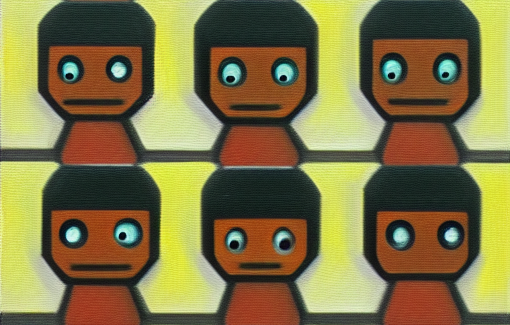

In [ ]:
#| echo: false
load_image_pil('images/An_oil_painting_of_a_grid_of_tiny_robot_faces_in_rows.png')

In this lesson we're going to look at some uses of large pretrained neural networks, and try to understand why they work as well as they do. To keep things organised, the content has been split between this notebook and two bonus notebooks. 

### Extracting Represenations from Pretrained Models

VGG16 was a fairly popular CNN that improved upon the famous AlexNet architecture. It has since been supeceeded by more complex networks but it still works great for our purposes. The architecture is something like the following ([source](https://https://neurohive.io/en/popular-networks/vgg16/)):

![](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

We can load it like so (check the imports section at the start of this notebook for the relevant imports):

In [ ]:
vgg = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

In [ ]:
# vgg # Uncomment to show the sumary

In [ ]:
# Random 'images'
x = torch.randn(8, 3, 128, 128) 

# Normalize with the same stats used during model training
def normalize(x):
    mean = torch.tensor([0.485, 0.456, 0.406])[:,None,None]
    std = torch.tensor([0.229, 0.224, 0.225])[:,None,None]
    x = (x-mean) / std
    return x
x = normalize(x)

# Pass through the model
vgg(x).shape

torch.Size([8, 1000])

In [ ]:
def get_penultimate_features(x):
    x = vgg.features(x)
    x = vgg.avgpool(x)
    x = torch.flatten(x, 1)
    for l in vgg.classifier[:-3]:
        x = l(x)
    return x

features = get_penultimate_features(x)
features.shape

torch.Size([8, 4096])

For each image we now have a feature vector containing 4096 values.

What can we do with these? Let's use them for image search!

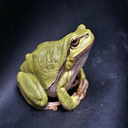

In [ ]:
frog_image = pil_from_url("https://images.pexels.com/photos/70083/frog-macro-amphibian-green-70083.jpeg?auto=compress&cs=tinysrgb&w=1600", size=(128, 128))
frog_image

Similarities: tensor([0.3742, 0.4047, 0.3873, 0.6293, 0.5818, 0.5095, 0.3890, 0.5207, 0.4447,
        0.5527, 0.6004, 0.5090, 0.6598], grad_fn=<SumBackward1>)
Best match: images/frog.png


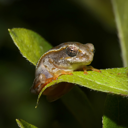

In [ ]:
# Get features from the frog image we're searching with
frog_features = get_penultimate_features(normalize(pil_to_tensor(frog_image)))

# Get featurs for all images in the images/ folder
image_files = glob.glob('images/*')
pil_images = [load_image_pil(im, size=(128, 128)) for im in image_files]
images = [pil_to_tensor(pil_image) for pil_image in pil_images]
x = torch.cat(images, dim=0)
image_features = get_penultimate_features(normalize(x))

# Calculate the similarities
cosine_sim =  torch.nn.CosineSimilarity()
similarities = cosine_sim(frog_features, image_features)
print('Similarities:', similarities)
best_match_idx = torch.argmax(similarities).item()
print('Best match:', image_files[best_match_idx])
pil_images[best_match_idx]

Some variant of this is used for most reverse-image-search implementations, and can be an extremely useful way to quickly 'search' a database of images, especially if you pre-compute the features for each image as it is added. Choosing how the network used for feature extraction is trained can determine what kinds of features are used - for example, a face recognition network will have features useful for finding similar faces, and can be used to find pictures of a specific person in a dataset.

## Transfer Learning

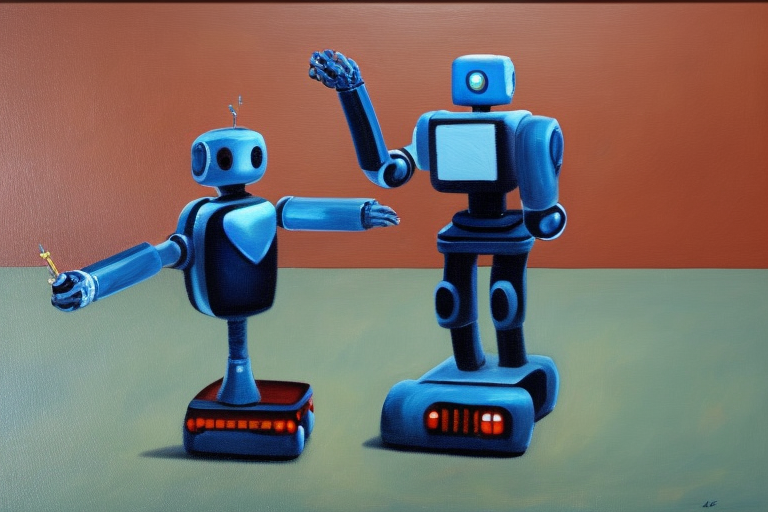

In [ ]:
#|echo: false
load_image_pil('images/A_robot_passes_the_baton_to_another_robot__oil_on_canvas.png')

As we said in the introduction, these learned 'features' capture a lot of useful information. When training an image classification network (for example) it is often beneficial to begin with a pretrained network rather than starting from scratch for this reason. Look at the bonus notebook to see an example of this in action, implemented in two different ways. 

Classifying Imagenet images is a pretty good pretraining task, and models trained on Imagenet tend to transfer well to other tasks. But this is not the only game in town! For specific applications, finding a pre-training task with lots of relevant data can help provide a model that will be a better starting point for downstream tasks. One example: training a model on satellite imagery on the task of predicting night-time light emmisions results in a model that has learn features associated with buildings and economic activity, which in turn can be fine-tuned on the task of estimating financial wellbeing from satellite imagery, as in [this great paper from 2016](https://science.sciencemag.org/content/353/6301/790). More generally, something like CLIP (which we'll see in lesson 5) tends to learn extremely useful representations as a result of beig trained to associate images with captions across a large dataset.

## Style Transfer

Remember how we said that early layers in a network tend to learn simpler features like colour and texture, while later layers capture more complex shapes? We're going to take advantage of this to do a little bit of magic. We'll take two images, a content image and a style image. Then we'll feed both through a network and record the activations at various layers. Finally, we will try to optimize the pixels of a new image (or anything that produces an image) such that: <br>

- The content features (from later layers of the network) roughly match those from the content image <br>
- The **types** of style features (from early layers) are similar to those from the style image <br>

Comparing the content features is relatively simple - something like MSE or MAE will suffice. But for the style features, we don't want features in the same **places**, we only care that the same **types** of feature appear. The bonus notebook has three different takes on ways to measure this, and I hope to add more explanation in a dedicated section soon.

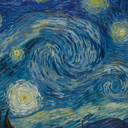

In [ ]:
style_image = pil_from_url("https://i.pinimg.com/originals/c3/b4/38/c3b438401bab3e91b487cd30309224f7.gif", size=(512, 512)).convert('RGB')
style_image.resize((128, 128)) # Small for preview

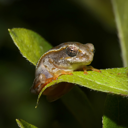

In [ ]:
content_image = load_image_pil('images/frog.png', size=(512, 512))
content_image.resize((128, 128)) # Small for preview

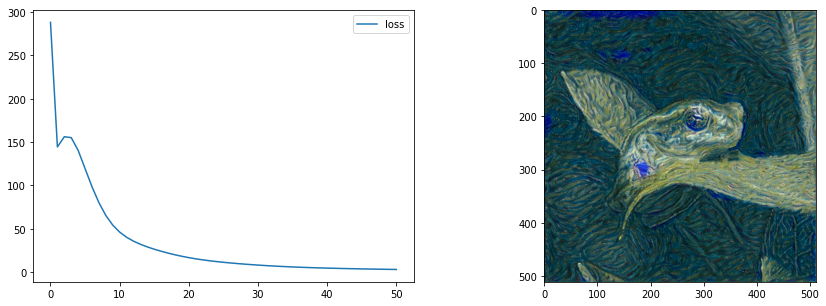

In [ ]:
from tglcourse.generation_utils import PixelGenerator, VincentStyleLossToTarget, ContentLossToTarget, optimise

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

style_loss_fn = VincentStyleLossToTarget(pil_to_tensor(style_image).to(device), size=512, style_layers = [3, 6, 9, 11])
content_loss_fn = ContentLossToTarget(pil_to_tensor(content_image).to(device))

# The pixels we'll optimise
gen = PixelGenerator(512, init_image=content_image).to(device)

# The optimizer - feel free to try different ones here
opt = torch.optim.AdamW(gen.parameters(), lr=0.05, weight_decay=1e-6)

optimise(gen, loss_functions=[style_loss_fn, content_loss_fn], optimizer=opt, n_steps=60)

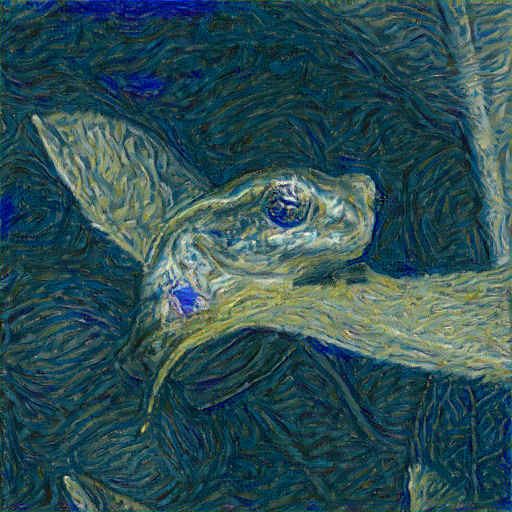

In [ ]:
tensor_to_pil(gen())

Pretty neat hey! More background in the lesson live-stream and the bonus notebook 'Fun with Generators and Losses'.

## A Dose of Ethics: I Like Your Style

Style transfer is extremely fun. It is tempting to grab some random pics from Google Image Search and start playing, but please pause for a second and imagine yourself in the shoes of the artist or photographer whose work you're about to download and modify. Perhaps you'd be happy to see your work used creatively, perhaps you'd be outraged. The image might have a licence that specifically restricts re-use or modification, and by using it you might be 'ripping off' a characteristic composition or style from someone who'd prefer you didn't! Better to avoid any potential pitfalls and stick with your own images or works that are explicity in the public domain (or at least licenced permissively) - especially if you're considering making money from the results. 

Page stats: Total Hits: [![HitCount](https://hits.dwyl.com/johnowhitaker/tglcourse.svg?style=flat-square&show=unique)](http://hits.dwyl.com/johnowhitaker/tglcourse)
Page visitors:
![visitor badge](https://page-views.glitch.me/badge?page_id=tglcourse.l04)